# Ideal Location for Alternative Energy

## Preparing Data

In [37]:
import pandas as pd
import numpy as np
import gmaps
import matplotlib.pyplot as plt

# Google developer API key
from gkey import gkey

In [38]:
# Import weather data file
path_weather = "data/cleandata/weatherdata_v2.csv"
data_weather = pd.read_csv(path_weather)
data_weather.head()

,ID,Year,Month,Element,Avg Value
0,USC00050109,2011,1,AWND,41.193548
1,USC00050109,2011,2,AWND,42.250000
2,USC00050109,2011,3,AWND,40.548387
3,USC00050109,2011,4,AWND,47.533333
4,USC00050109,2011,5,AWND,48.838710


In [39]:
len(data_weather['ID'].unique())

1082

In [40]:
# Import stations list for lat and long
path_station = "data/cleandata/Stations.csv"
data_station = pd.read_csv(path_station)
data_station.head()

,ID,Latitude,Longitude,Elevation,State,Name
0,US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA)
1,US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW
2,US10adam001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S
3,US10adam002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW
4,US10adam003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW


In [41]:
#Merge both data frames
data = pd.merge(data_weather, data_station, on="ID",how='inner')
data = data.rename(columns={'Avg Value':'Avg Monthly Value'})
data.head()

,ID,Year,Month,Element,Avg Monthly Value,Latitude,Longitude,Elevation,State,Name
0,USC00050109,2011,1,AWND,41.193548,40.155,-103.1417,1384.4,CO,AKRON 4 E
1,USC00050109,2011,2,AWND,42.250000,40.155,-103.1417,1384.4,CO,AKRON 4 E
2,USC00050109,2011,3,AWND,40.548387,40.155,-103.1417,1384.4,CO,AKRON 4 E
3,USC00050109,2011,4,AWND,47.533333,40.155,-103.1417,1384.4,CO,AKRON 4 E
4,USC00050109,2011,5,AWND,48.838710,40.155,-103.1417,1384.4,CO,AKRON 4 E


In [42]:
# Add 'Month Counts' column to determine how many months of data each station has.
data['Month Counts'] = data.groupby(['ID'])['Month'].transform('count')
data.head()

,ID,Year,Month,Element,Avg Monthly Value,Latitude,Longitude,Elevation,State,Name,Month Counts
0,USC00050109,2011,1,AWND,41.193548,40.155,-103.1417,1384.4,CO,AKRON 4 E,16
1,USC00050109,2011,2,AWND,42.250000,40.155,-103.1417,1384.4,CO,AKRON 4 E,16
2,USC00050109,2011,3,AWND,40.548387,40.155,-103.1417,1384.4,CO,AKRON 4 E,16
3,USC00050109,2011,4,AWND,47.533333,40.155,-103.1417,1384.4,CO,AKRON 4 E,16
4,USC00050109,2011,5,AWND,48.838710,40.155,-103.1417,1384.4,CO,AKRON 4 E,16


In [43]:
# Only keep stations with at least 12 months of data.
data = data[data['Month Counts']>=12]
len(data['ID'].unique())

1054

In [44]:
# Calculate average number for each element for each station
data_group = data.groupby(['ID', 'Element','State']).mean()[['Avg Monthly Value', 'Latitude', 'Longitude', 'Elevation']]
data_group = data_group.rename(columns={'Avg Monthly Value': 'Value'})


In [45]:
# Convert df to dataframe
df = data_group.reset_index()
df.head()

,ID,Element,State,Value,Latitude,Longitude,Elevation
0,USC00050109,AWND,CO,47.200534,40.1550,-103.1417,1384.4
1,USC00051996,AWND,CO,21.682163,40.8600,-102.8031,1130.5
2,USC00052947,AWND,CO,40.141416,40.6483,-102.8594,1297.2
3,USC00053005,AWND,CO,15.373269,40.5764,-105.0858,1525.2
4,USC00053261,AWND,CO,44.030606,39.7053,-105.6997,2596.9


In [46]:
max_longitude = df['Longitude'].max()
max_longitude
df.loc[(df['Longitude']==max_longitude),:]

,ID,Element,State,Value,Latitude,Longitude,Elevation
1466,USW00045715,ACMH,AK,87.477543,52.7167,174.1,37.2
1467,USW00045715,ACSH,AK,88.246457,52.7167,174.1,37.2


In [47]:
max_latitude = df['Latitude'].max()
max_latitude
df.loc[(df['Latitude']==max_latitude),:]

,ID,Element,State,Value,Latitude,Longitude,Elevation
1463,USW00027502,AWND,AK,57.02275,71.2833,-156.7814,9.4


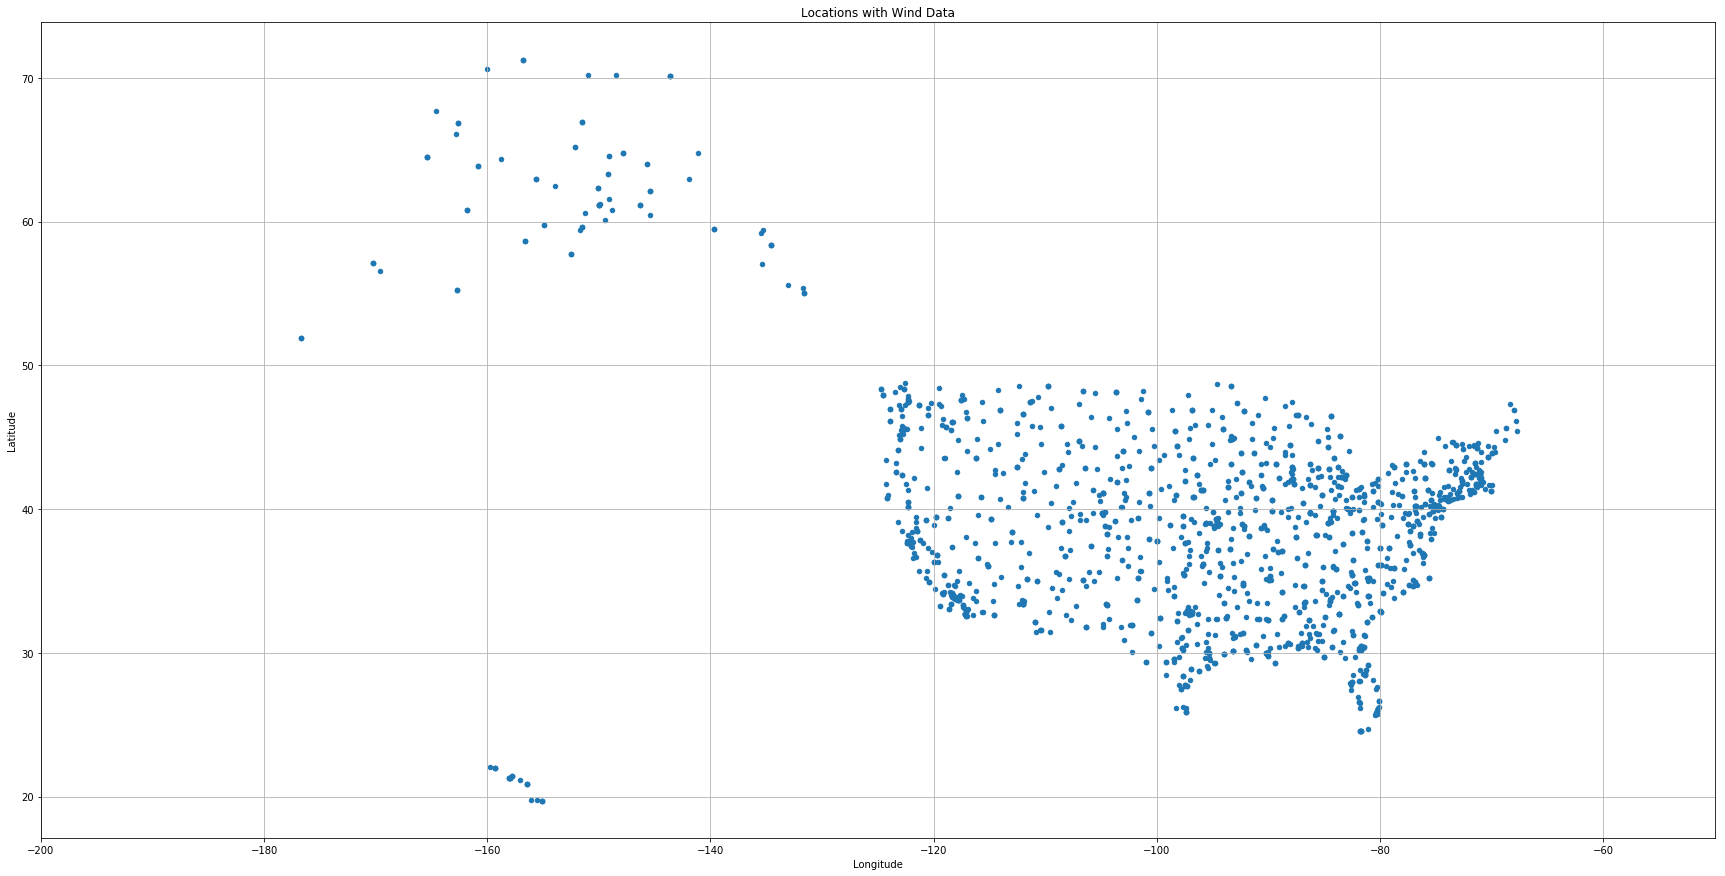

In [48]:
# Plot all stations with wind data
df.plot(kind="scatter", x='Longitude', y='Latitude', grid = True,
       figsize = (30,15), title="Locations with Wind Data")
plt.xlim(-200,-50)
plt.savefig('Locations with Wind Data.png')
plt.show()

## Find locations with optimal wind speed

In [49]:
# AWND: Average daily wind speed (tenths of meters per second)
# PSUN: Daily percent of possible sunshine (percent)
# ACMH: Average cloudiness midnight to midnight from manual observations (percent)
# ACSH: Average cloudiness sunrise to sunset from manual observations (percent)
# ACMC: Average cloudiness midnight to midnight from 30-second ceilometer data (percent)
# ACSC: Average cloudiness sunrise to sunset from 30-second ceilometer data (percent)
data['Element'].unique()

array(['AWND', 'PSUN', 'ACMH', 'ACSH', 'ACMC', 'ACSC'], dtype=object)

In [50]:
# Cut in speed is 3.5 m/s, the typical cut-in speed, when a small turbine starts generating power.
# Convert wind speed to tenths of m/s
cut_in_wind = 35

# Locations that wind can generate power.
suitable_winds = df.loc[(df['Element']=='AWND') & (df['Value']>= cut_in_wind),:]
suitable_winds.to_csv('Suitable_Wind.csv', index = False)
suitable_winds.describe()

,Value,Latitude,Longitude,Elevation
count,449.000000,449.000000,449.000000,449.000000
mean,43.963933,39.916689,-99.167419,487.230735
std,11.209840,7.956981,19.867382,541.370030
min,35.080982,19.760000,-176.650000,1.200000
25%,38.378428,35.388900,-104.688300,95.100000
50%,41.924313,40.316100,-97.101900,283.500000
75%,46.816117,43.020600,-86.650000,695.900000
max,190.583333,71.283300,-68.017200,2596.900000


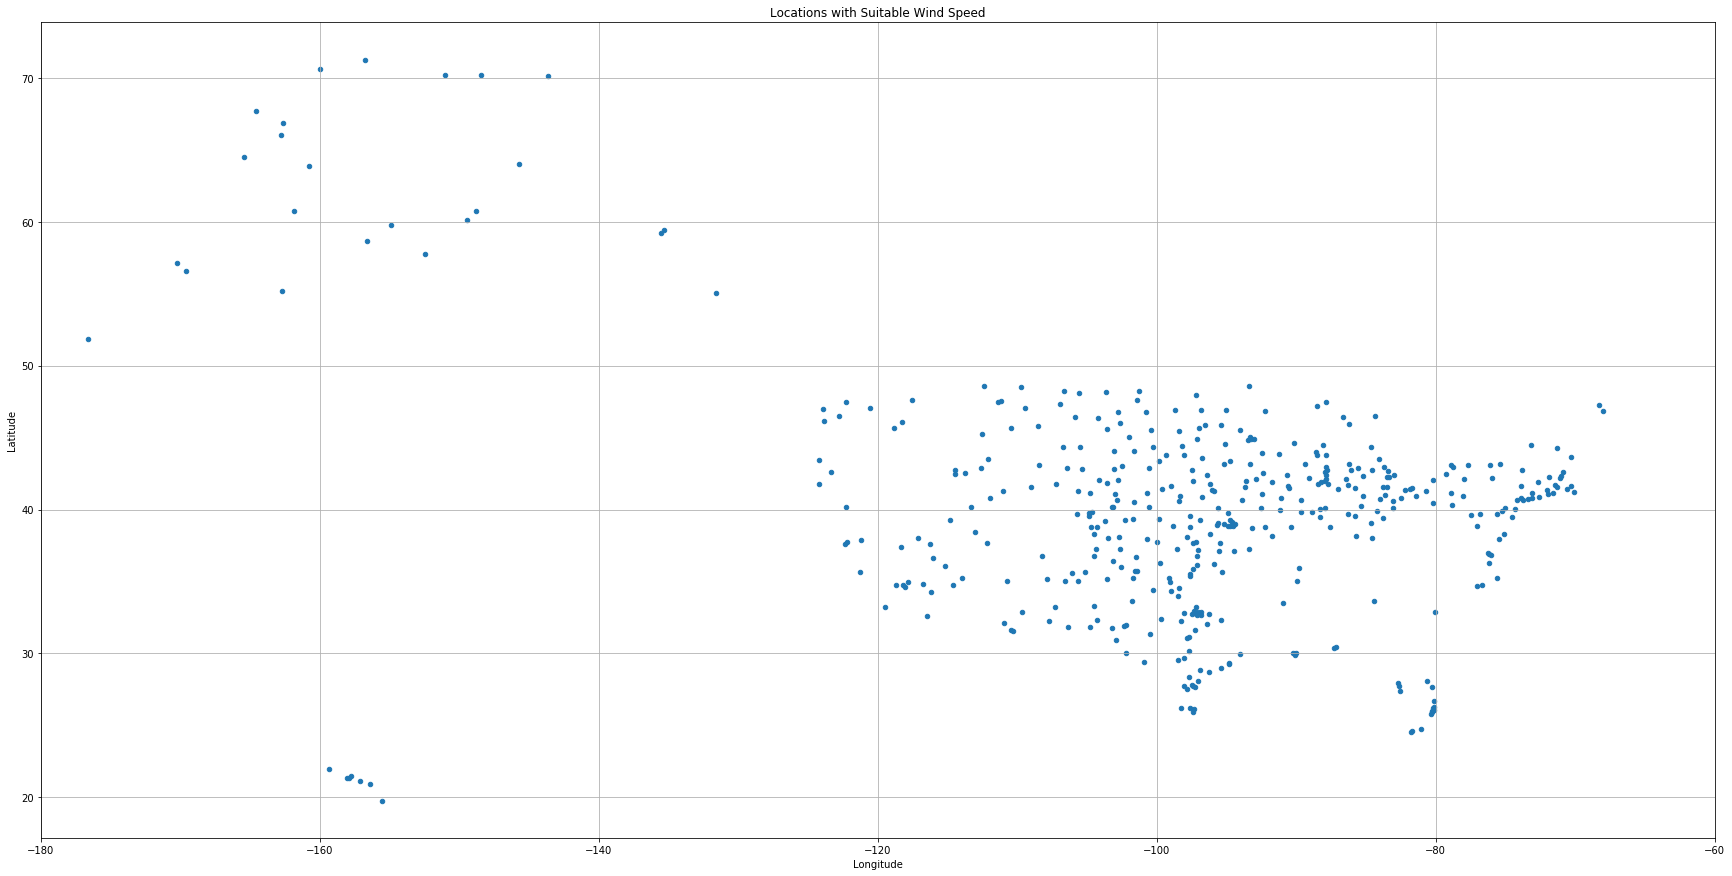

In [51]:
# Plot all stations with suitable wind speed data
suitable_winds.plot(kind="scatter", x='Longitude', y='Latitude', grid = True,
       figsize = (30,15), title="Locations with Suitable Wind Speed")
plt.xlim(-180,-60)
plt.savefig('Locations with Suitable Wind Speed.png')
plt.show()

In [52]:
# Optimal wind speed: 10–15 m/s, 36–54 kph (10–15 m/s) produces maximum generation power.
# Convert wind speed to tenths of m/s
optimal_wind = 100

# Locations with optimal wind to generate power.
optimal_winds = df.loc[(df['Element']=='AWND') & (df['Value']>= optimal_wind),:]
optimal_winds

,ID,Element,State,Value,Latitude,Longitude,Elevation
733,USW00014755,AWND,NH,162.276405,44.2667,-71.2994,1910.2
744,USW00014761,AWND,PA,190.583333,40.9167,-78.0667,592.8


## Map Location to Google Map

In [53]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [54]:
locations = suitable_winds[['Latitude','Longitude']].astype(float)
wind_speed = suitable_winds['Value'].astype(float)


In [55]:
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=wind_speed, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 0
heat_layer.point_radius = 0.5

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [56]:
suitable_winds.head()

,ID,Element,State,Value,Latitude,Longitude,Elevation
0,USC00050109,AWND,CO,47.200534,40.1550,-103.1417,1384.4
2,USC00052947,AWND,CO,40.141416,40.6483,-102.8594,1297.2
4,USC00053261,AWND,CO,44.030606,39.7053,-105.6997,2596.9
7,USC00116344,AWND,IL,36.978536,40.1100,-87.9567,205.7
12,USC00185934,AWND,MD,42.654162,39.7194,-76.8028,262.1


In [57]:
# Create list of suitable states
states_df = suitable_winds['State'].value_counts()
states_df = states_df.reset_index()
#headers = ['State', 'Counts']
#states_df = states_df[headers]
states_df = states_df.rename(columns={'State':'Counts'})
states_df = states_df.rename(columns={'index':'State'})
states_df.head()

,State,Counts
0,TX,54
1,AK,24
2,KS,21
3,NE,19
4,MI,18


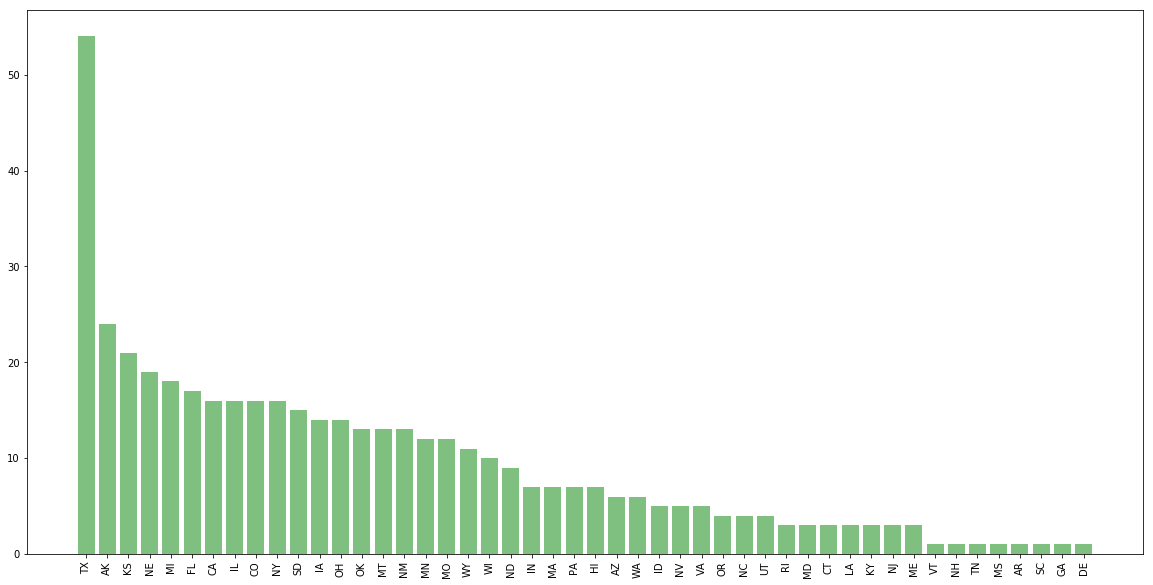

In [58]:
xAxis = np.arange(len(states_df['State']))
xAxis.tolist()
tick_locations = [value + 0.4 for value in xAxis]

#Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,10))
plt.bar(xAxis, states_df["Counts"], color='green', alpha=0.5, align="edge")
plt.xticks(tick_locations, states_df["State"], rotation="vertical")
plt.savefig('States with Suitable Wind Spee.png')